# ECCO SALT BUDGET

In [1]:
import os

os.environ['NUMPY_EXPERIMENTAL_ARRAY_FUNCTION'] = '0'

In [2]:
from dask.distributed import Client, progress
from dask_kubernetes import KubeCluster

cluster = KubeCluster(n_workers=10)#, env={"NUMPY_EXPERIMENTAL_ARRAY_FUNCTION": "0"})

In [3]:
client = Client(cluster)
client

Client Scheduler: tcp://10.32.60.111:46137 Dashboard: /user/0000-0002-8176-9465/proxy/8787/status,Cluster Workers: 10 Cores: 20 Memory: 115.00 GB


In [4]:
import xarray as xr
from matplotlib import pyplot as plt
#import gcsfs
import dask
import dask.array as dsa
import numpy as np
import intake
%matplotlib inline

/srv/conda/envs/notebook/lib/python3.7/site-packages/tqdm/autonotebook/__init__.py:18: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)
/srv/conda/envs/notebook/lib/python3.7/site-packages/intake/source/discovery.py:136: FutureWarning: The drivers ['esm_metadatastore'] do not specify entry_points and were only discovered via a package scan. This may break in a future release of intake. The packages should be updated.
  FutureWarning)


In [5]:
from xmitgcm.llcreader.llcmodel import faces_dataset_to_latlon

In [6]:
ecco_url = 'https://raw.githubusercontent.com/pangeo-data/pangeo-datastore/master/intake-catalogs/ocean.yaml'
ecco_cat = intake.Catalog(ecco_url)
ds = ecco_cat["ECCOv4r3"].to_dask()

In [7]:
ds_ll = faces_dataset_to_latlon(ds)
ds_ll

<xarray.Dataset>
Dimensions:    (face: 13, i: 360, i_g: 360, j: 270, j_g: 270, k: 50, k_l: 50, k_p1: 51, k_u: 50, time: 288, time_snp: 287)
Coordinates:
  * time_snp   (time_snp) datetime64[ns] 1992-02-01 1992-03-01 ... 2015-12-01
  * i_g        (i_g) int64 0 1 2 3 4 5 6 7 8 ... 352 353 354 355 356 357 358 359
  * time       (time) datetime64[ns] 1992-01-15 1992-02-13 ... 2015-12-14
  * face       (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
  * j_g        (j_g) int64 0 1 2 3 4 5 6 7 8 ... 262 263 264 265 266 267 268 269
  * j          (j) int64 0 1 2 3 4 5 6 7 8 ... 262 263 264 265 266 267 268 269
  * k_u        (k_u) int64 0 1 2 3 4 5 6 7 8 9 ... 40 41 42 43 44 45 46 47 48 49
  * k          (k) int64 0 1 2 3 4 5 6 7 8 9 ... 40 41 42 43 44 45 46 47 48 49
  * k_p1       (k_p1) int64 0 1 2 3 4 5 6 7 8 9 ... 42 43 44 45 46 47 48 49 50
  * i          (i) int64 0 1 2 3 4 5 6 7 8 ... 352 353 354 355 356 357 358 359
  * k_l        (k_l) int64 0 1 2 3 4 5 6 7 8 9 ... 40 41 42 43 44 45 46 47 48 4

/srv/conda/envs/notebook/lib/python3.7/site-packages/xarray/core/dataarray.py:2447: FutureWarning: roll_coords will be set to False in the future. Explicitly set roll_coords to silence warning.
  shifts=shifts, roll_coords=roll_coords, **shifts_kwargs)


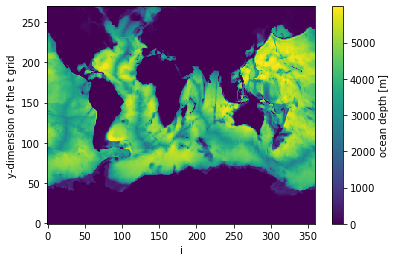

In [8]:
#ryan fixed the <i,j,k> coords
ds_ll.Depth.roll(i=100).drop('i').plot()

In [9]:
ds_ll_drop = ds_ll.drop(['i', 'j', 'k', 'i_g', 'j_g', 'k_u', 'k_l', 'k_p1'])

In [10]:
# a trick to make things work a bit faster
coords = ds_ll_drop.coords.to_dataset().reset_coords().roll(i=100, i_g=100)
ds = ds_ll_drop.reset_coords(drop=True).roll(i=100, i_g=100)
ds

/srv/conda/envs/notebook/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: roll_coords will be set to False in the future. Explicitly set roll_coords to silence warning.
  
/srv/conda/envs/notebook/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: roll_coords will be set to False in the future. Explicitly set roll_coords to silence warning.
  This is separate from the ipykernel package so we can avoid doing imports until


<xarray.Dataset>
Dimensions:    (face: 13, i: 360, i_g: 360, j: 270, j_g: 270, k: 50, k_l: 50, k_p1: 51, k_u: 50, time: 288, time_snp: 287)
Coordinates:
  * time_snp   (time_snp) datetime64[ns] 1992-02-01 1992-03-01 ... 2015-12-01
  * time       (time) datetime64[ns] 1992-01-15 1992-02-13 ... 2015-12-14
  * face       (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
Dimensions without coordinates: i, i_g, j, j_g, k, k_l, k_p1, k_u
Data variables:
    ADVr_SLT   (time, k_l, j, i) float32 dask.array<shape=(288, 50, 270, 360), chunksize=(1, 50, 90, 90)>
    ADVr_TH    (time, k_l, j, i) float32 dask.array<shape=(288, 50, 270, 360), chunksize=(1, 50, 90, 90)>
    DFrE_SLT   (time, k_l, j, i) float32 dask.array<shape=(288, 50, 270, 360), chunksize=(1, 50, 90, 90)>
    DFrE_TH    (time, k_l, j, i) float32 dask.array<shape=(288, 50, 270, 360), chunksize=(1, 50, 90, 90)>
    DFrI_SLT   (time, k_l, j, i) float32 dask.array<shape=(288, 50, 270, 360), chunksize=(1, 50, 90, 90)>
    DFrI_TH    (time, k_l,

In [12]:
ds.ADVr_SLT

<xarray.DataArray 'ADVr_SLT' (time: 288, k_l: 50, j: 270, i: 360)>
dask.array<shape=(288, 50, 270, 360), dtype=float32, chunksize=(1, 50, 90, 90)>
Coordinates:
  * time     (time) datetime64[ns] 1992-01-15 1992-02-13 ... 2015-12-14
Dimensions without coordinates: k_l, j, i
Attributes:
    long_name:      Vertical   Advective Flux of Salinity
    standard_name:  ADVr_SLT
    units:          psu.m^3/s

In [14]:
ds.time_snp

<xarray.DataArray 'time_snp' (time_snp: 287)>
array(['1992-02-01T00:00:00.000000000', '1992-03-01T00:00:00.000000000',
       '1992-04-01T00:00:00.000000000', ..., '2015-10-01T00:00:00.000000000',
       '2015-11-01T00:00:00.000000000', '2015-12-01T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time_snp  (time_snp) datetime64[ns] 1992-02-01 1992-03-01 ... 2015-12-01
Attributes:
    axis:               T
    c_grid_axis_shift:  0.5
    long_name:          Time
    standard_name:      time

In [18]:
ds.time[1:-1]

<xarray.DataArray 'time' (time: 286)>
array(['1992-02-13T00:00:00.000000000', '1992-03-15T00:00:00.000000000',
       '1992-04-14T00:00:00.000000000', ..., '2015-09-14T00:00:00.000000000',
       '2015-10-15T00:00:00.000000000', '2015-11-14T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 1992-02-13 1992-03-15 ... 2015-11-14
Attributes:
    axis:           T
    long_name:      Time
    standard_name:  time

In [19]:
dt.time

<xarray.DataArray 'time' (time: 286)>
array(['1992-03-01T00:00:00.000000000', '1992-04-01T00:00:00.000000000',
       '1992-05-01T00:00:00.000000000', ..., '2015-10-01T00:00:00.000000000',
       '2015-11-01T00:00:00.000000000', '2015-12-01T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 1992-03-01 1992-04-01 ... 2015-12-01
Attributes:
    axis:               T
    c_grid_axis_shift:  0.5
    long_name:          Time
    standard_name:      time

## Salt budget for WG (entire water column)

In [ ]:
sss_mean = ds.SALT.isel(k=0).mean(dim='time').load()

In [ ]:
surface_mask = (coords.hFacC[0]>0).load()
surface_mask

In [ ]:
sss_mean.where(surface_mask).plot(figsize=(12,6))
plt.grid();

In [ ]:
sss_mean_wg = sss_mean.sel(i=slice(75, 167), j=slice(35, 75))
surface_mask_wg = surface_mask.sel(i=slice(75, 167), j=slice(35, 75))

In [ ]:
sss_mean_wg.where(surface_mask_wg).plot(figsize=(12,6))
plt.grid();

In [ ]:
lower_j = 0
upper_j = 39
left_i = 0
right_i = 90

In [ ]:
fig, ax = plt.subplots(figsize=(15, 8), subplot_kw={'facecolor': '0.5'})
sss_mean_wg.where(surface_mask_wg).plot(ax=ax,  vmin=30, vmax=35)
ax.plot([left_i, right_i], [upper_j, upper_j], color='k')
ax.plot([right_i, right_i], [lower_j, upper_j], color='k')
ax.plot([left_i, left_i], [lower_j, upper_j], color='k')
ax.plot([left_i, right_i], [lower_j, lower_j], color='k')

#ax.set_xlim([-40, 55])
#ax.set_ylim([25, 85])
plt.title('SST\nLat[-71.5, -65.5]\nLon[-62, 30]')
#plt.savefig('ECCO-salt-surf-boundaries', format='pdf');

In [ ]:
lower_lat = 35 #9
upper_lat = 75 #44
left_lon = 75 #21
right_lon = 167 #120

In [ ]:
#set the boundaries
lat_range = dict(j=slice(lower_lat, upper_lat))
lon_range = dict(i=slice(left_lon, right_lon))

In [ ]:
#advective flux
adv_flux_y = ds.ADVy_SLT.isel(**lon_range, j_g=upper_lat).sum(dim=['i', 'k']).load()
adv_flux_x = ds.ADVx_SLT.isel(**lat_range, i_g=right_lon).sum(dim=['j', 'k']).load()

adv_flux = adv_flux_x + adv_flux_y
adv_flux.load()
#units: (˚C m^3)/s

In [ ]:
plt.figure(figsize=(12,6))

adv_flux_x.plot(label='x')
adv_flux_y.plot(label='y')
plt.legend()

In [ ]:
#diffusive flux
diff_flux_y = ds.DFyE_SLT.isel(**lon_range, j_g=upper_lat).sum(dim=['i', 'k']).load()
diff_flux_x = ds.DFxE_SLT.isel(**lat_range, i_g=right_lon).sum(dim=['j', 'k']).load()

diff_flux = diff_flux_x + diff_flux_y
diff_flux.load()
#units: (˚C m^3)/s

In [ ]:
plt.figure(figsize=(12,6))
diff_flux_x.plot(label='x')
diff_flux_y.plot(label='y')
plt.legend()

In [ ]:
#vertical flux
s_flux_z = (ds.SFLUX * coords.rA * coords.hFacC.isel(k=0)).isel(**lat_range, **lon_range).sum(
                                                                                dim=['i','j'])
s_flux_z.load()
#units: g/s

In [ ]:
runit2mass = 1.035e3 #kg/m^3
surface_term = s_flux_z / runit2mass

surface_term.load()

#ECCO has nonlinear surface so don't wry about 'lin_fs_correction' term
#units: (psu * m^3)/s

In [ ]:
surface_term.plot(label='surf')

In [ ]:
salt_scaled = (ds.SALT_snp * (1 + (ds.ETAN_snp / coords.Depth))).diff('time_snp')
salt_scaled
#units: g/kg (psu)

In [ ]:
#forcing salt_scaled to have same timestamp as ds.dt by creating new data array called "salt_scaled"
salt_scaled = xr.DataArray(salt_scaled.data, dims=['time','k','j','i'], 
                            coords={'time': ds.dt[1:287].time.data
#                                     , 'k': theta_scaled['theta_scaled.k.dims'].data, 
#                                                      'j': theta_scaled['theta_scaled.j.dims'].data, 
#                                                      'i': theta_scaled['theta_scaled.i.dims'].data
                                   })
salt_scaled

In [ ]:
salt_tend = (salt_scaled / ds.dt[1:287])
#units: g/kg*s (psu/s)

In [ ]:
salt_plume = ((ds.oceSPtnd * coords.rA)/runit2mass).isel(**lat_range, **lon_range).sum(
                                                                    dim=['i','j', 'k'])
salt_plume.load()

In [ ]:
totstend_weddell = (salt_tend * coords.rA * coords.drF * coords.hFacC).isel(**lat_range, **lon_range).sum(
                                                                            dim=['i', 'j', 'k']).load()
#units: g*m^3 / kg*s  (psu * m^3 / s)

In [ ]:
plt.figure(figsize=(12,6))
rhs = - adv_flux[1:287] - diff_flux[1:287] + surface_term[1:287] + salt_plume[1:287]
lhs = totstend_weddell
rhs.plot(label='rhs')
lhs.plot(label='lhs')
plt.legend(loc=4)
plt.grid()
plt.title('Salt budget for WG \n(entire column)')
plt.xlim('1992', '2016')
plt.savefig('ECCO-salt-surf-rhs-lhs-timeseries', format='pdf');

In [ ]:
rhs_terms = xr.merge([adv_flux.rename('adv_flux'),
                      diff_flux.rename('diff_flux'),
                      surface_term.rename('surf_flux')])

In [ ]:
plt.figure(figsize=(12,6))
rhs_terms.to_array().plot.line(x='time')
plt.grid();

In [ ]:
all_terms = xr.merge(adv_flux.rename('adv_flux'),
                     diff_flux.rename('diff_flux'),
                     surface_term.rename('surf_flux'),
                     totstend.rename('totstend'))

In [ ]:
all_terms.to_array().plot.line(x='time')
plt.legend()
#plt.savefig('ECCO-salt-surf-all-terms', format='pdf')

## Salt budget for Lower WG (-2,046m to bottom)

In [ ]:
sss_mean_lower = ds.SALT.isel(k=36).mean(dim='time').load()

In [ ]:
surface_mask_lower = (coords.hFacC.isel(k=36)>0).load()

In [ ]:
sss_mean_lower.where(surface_mask_lower).plot(figsize=(12,6))
plt.grid();

In [ ]:
sss_mean_wg_lower = sss_mean_lower.sel(i=slice(75, 167), j=slice(35, 75))
surface_mask_wg_lower = surface_mask_lower.sel(i=slice(75, 167), j=slice(35, 75))

In [ ]:
sss_mean_wg_lower.where(surface_mask_wg_lower).plot(figsize=(12,6))
plt.grid();

In [ ]:
lower_j = 0
upper_j = 39
left_i = 0
right_i = 90

In [ ]:
ds.ADVx_TH

In [ ]:
fig, ax = plt.subplots(figsize=(15, 8), subplot_kw={'facecolor': '0.5'})
sss_mean_wg_lower.where(surface_mask_wg_lower).plot(ax=ax,  vmin=34.5, vmax=35)
ax.plot([left_i, right_i], [upper_j, upper_j], color='k')
ax.plot([right_i, right_i], [lower_j, upper_j], color='k')
ax.plot([left_i, left_i], [lower_j, upper_j], color='k')
ax.plot([left_i, right_i], [lower_j, lower_j], color='k')

#ax.set_xlim([-40, 55])
#ax.set_ylim([25, 85])
plt.title('SST\nLat[-71.5, -65.5]\nLon[-62, 30]');

In [ ]:
#index locations corresponding to above lat/lon coordinates
lower_lat_lower = 35
upper_lat_lower = 75
left_lon_lower = 75
right_lon_lower = 167


lower_cell_range = dict(k_l=[36, 49])
lower_cell_range_z = dict(k=slice(36, 49))

In [ ]:
#set the boundaries
lat_range_lower = dict(j=slice(lower_lat_lower, upper_lat_lower))
lon_range_lower = dict(i=slice(left_lon_lower, right_lon_lower))

In [ ]:
#advective flux
adv_flux_y_lower = ds.ADVy_SLT.isel(**lon_range_lower, j_g=upper_lat_lower, **lower_cell_range_z).sum(
                                                                                 dim=['i','k']).load()
adv_flux_x_lower = ds.ADVx_SLT.isel(**lat_range_lower, i_g=right_lon_lower, **lower_cell_range_z).sum(
                                                                                 dim=['j','k']).load()
adv_flux_z_lower = ds.ADVr_SLT.isel(**lon_range_lower, **lat_range_lower, k_l=36).sum(dim=['i', 'j']
                                                                                            ).load()

adv_flux_lower = adv_flux_x_lower + adv_flux_y_lower + adv_flux_z_lower
adv_flux_lower.load()
#units: (˚C m^3)/s

In [ ]:
plt.figure(figsize=(12,6))
adv_flux_x_lower.plot(label='x')
adv_flux_y_lower.plot(label='y')
adv_flux_z_lower.plot(label='z')
plt.legend();

In [ ]:
#diffusive flux
diff_flux_y_lower = ds.DFyE_SLT.isel(**lon_range_lower, j_g=upper_lat_lower, **lower_cell_range_z).sum(
                                                                                  dim=['i','k']).load()
diff_flux_x_lower = ds.DFxE_SLT.isel(**lat_range_lower, i_g=right_lon_lower, **lower_cell_range_z).sum(
                                                                                  dim=['j','k']).load()
diff_flux_z_lower = ((ds.DFrE_SLT.isel(**lon_range_lower, **lat_range_lower, k_l=36).sum(dim=['i', 'j'])
                    + ds.DFrI_SLT.isel(**lon_range_lower, **lat_range_lower, k_l=36).sum(dim=['i', 'j'])
                                                                                               ).load())

diff_flux_lower = diff_flux_x_lower + diff_flux_y_lower + diff_flux_z_lower
diff_flux_lower.load()
#units: (˚C m^3)/s

In [ ]:
plt.figure(figsize=(12,6))
diff_flux_x_lower.plot(label='x')
diff_flux_y_lower.plot(label='y')
diff_flux_z_lower.plot(label='z')
plt.legend()

In [ ]:
totstend_weddell_lower = (salt_tend * coords.rA * coords.drF * coords.hFacC).isel(
                         **lon_range_lower, **lat_range_lower, **lower_cell_range_z).sum(
                                                                            dim=['i', 'j','k'])
totstend_weddell_lower.load()
#units: (˚C m^3)/s

In [ ]:
totstend_weddell_lower.plot(figsize=(12,6))
plt.grid()

In [ ]:
salt_plume_lower = ((ds.oceSPtnd * coords.rA)/runit2mass).isel(**lat_range_lower, **lon_range_lower, 
                                                               **lower_cell_range_z).sum(
                                                               dim=['i','j','k'])
salt_plume_lower.load()

In [ ]:
plt.figure(figsize=(12,6))
rhs_lower = - adv_flux_lower[1:287] - diff_flux_lower[1:287] + salt_plume_lower[1:287]
lhs_lower = totstend_weddell_lower
rhs_lower.plot(label='rhs_lower')
lhs_lower.plot(label='lhs_lower')
plt.legend()
plt.grid()
plt.title('Salt budget for lower WG region\n(>2,046m)')
plt.xlim('1992', '2016');
#plt.savefig('SOSE-heat-inter-rhs-lhs-timeseries', format='pdf')

In [ ]:
rhs_terms_lower = xr.merge([adv_flux_lower.rename('adv'),
                            diff_flux_lower.rename('diff'),
                            salt_plume_lower.rename('salt_plume')])


In [ ]:
plt.figure(figsize=(12,6))
rhs_terms_lower.to_array().plot.line(x='time')